In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('website_traffic.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Page Views        2000 non-null   int64  
 1   Session Duration  2000 non-null   float64
 2   Bounce Rate       2000 non-null   float64
 3   Traffic Source    2000 non-null   object 
 4   Time on Page      2000 non-null   float64
 5   Previous Visits   2000 non-null   int64  
 6   Conversion Rate   2000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 109.5+ KB


In [15]:
df.describe()

,Page Views,Session Duration,Bounce Rate,Time on Page,Previous Visits,Conversion Rate
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,4.950500,3.022045,0.284767,4.027439,1.978500,0.982065
std,2.183903,3.104518,0.159781,2.887422,1.432852,0.065680
min,0.000000,0.003613,0.007868,0.068515,0.000000,0.343665
25%,3.000000,0.815828,0.161986,1.935037,1.000000,1.000000
50%,5.000000,1.993983,0.266375,3.315316,2.000000,1.000000
75%,6.000000,4.197569,0.388551,5.414627,3.000000,1.000000
max,14.000000,20.290516,0.844939,24.796182,9.000000,1.000000


In [16]:
df.isnull().sum()

Page Views          0
Session Duration    0
Bounce Rate         0
Traffic Source      0
Time on Page        0
Previous Visits     0
Conversion Rate     0
dtype: int64

In [17]:
numeric_df = df.select_dtypes(include=[np.number])

correlations = numeric_df.corr()['Conversion Rate'].sort_values()
print("\nCorrelation Coefficients with Conversion Rate:")
correlations


Correlation Coefficients with Conversion Rate:


Bounce Rate        -0.049051
Previous Visits     0.109496
Page Views          0.126635
Session Duration    0.177798
Time on Page        0.229669
Conversion Rate     1.000000
Name: Conversion Rate, dtype: float64

In [18]:
positive_correlations = correlations[correlations > 0].sort_values(ascending=False)

if positive_correlations.empty:
    raise ValueError("No features with positive correlation to the target variable.")

target = 'Conversion Rate'
features = positive_correlations.index.drop(target)

X = numeric_df[features].values
y = numeric_df[target].values

split_ratio = 0.8
split_index = int(len(X) * split_ratio)

x_train, x_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

x_train_b = np.c_[np.ones((x_train.shape[0], 1)), x_train]

result = np.linalg.inv(x_train_b.T @ x_train_b) @ x_train_b.T @ y_train

x_test_b = np.c_[np.ones((x_test.shape[0], 1)), x_test]
y_pred = x_test_b @ result

mae = np.mean(np.abs(y_test - y_pred))
print(f"\nMean Absolute Error (MAE): {mae:.2f}")

print("\nAnalysis of MAE:")
if mae < 1:
    print("The MAE is low, indicating good model performance.")
elif mae < 5:
    print("The MAE is moderate, suggesting room for improvement.")
else:
    print("The MAE is high, indicating the need for model improvement.")


Mean Absolute Error (MAE): 0.03

Analysis of MAE:
The MAE is low, indicating good model performance.


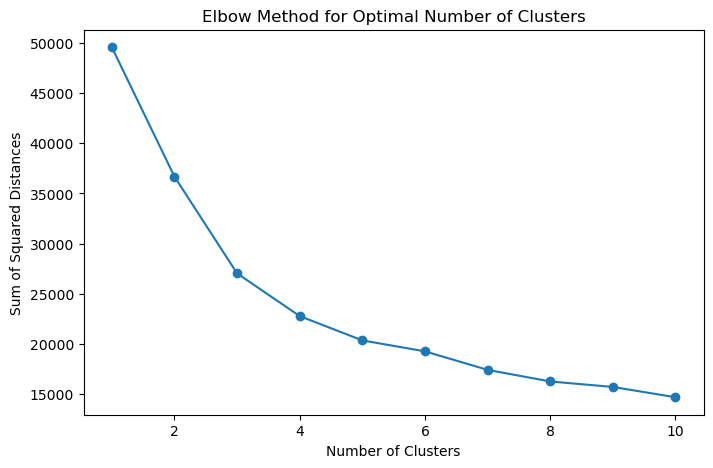

In [19]:
sse = []

for k in range(1, 11):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(100):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        clusters = np.argmin(distances, axis=1)
        new_centroids = np.array([X[clusters == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    sse.append(np.sum((X - centroids[clusters]) ** 2))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [20]:
optimal_clusters = 3
centroids = X[np.random.choice(X.shape[0], optimal_clusters, replace=False)]

for _ in range(100):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    clusters = np.argmin(distances, axis=1)
    new_centroids = np.array([X[clusters == i].mean(axis=0) for i in range(optimal_clusters)])
    if np.all(centroids == new_centroids):
        break
    centroids = new_centroids

df['Cluster'] = clusters

numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]
cluster_means = df_numeric.groupby('Cluster').mean()
print("\nCluster Analysis - Mean Values for Each Cluster:")
cluster_means


Cluster Analysis - Mean Values for Each Cluster:


,Page Views,Session Duration,Bounce Rate,Time on Page,Previous Visits,Conversion Rate
Cluster,,,,,,
0,5.046875,2.185164,0.289606,8.212989,1.953125,0.999956
1,4.941272,1.837666,0.284137,2.671381,2.024470,0.970788
2,4.852761,8.626250,0.280485,3.375295,1.840491,0.999889


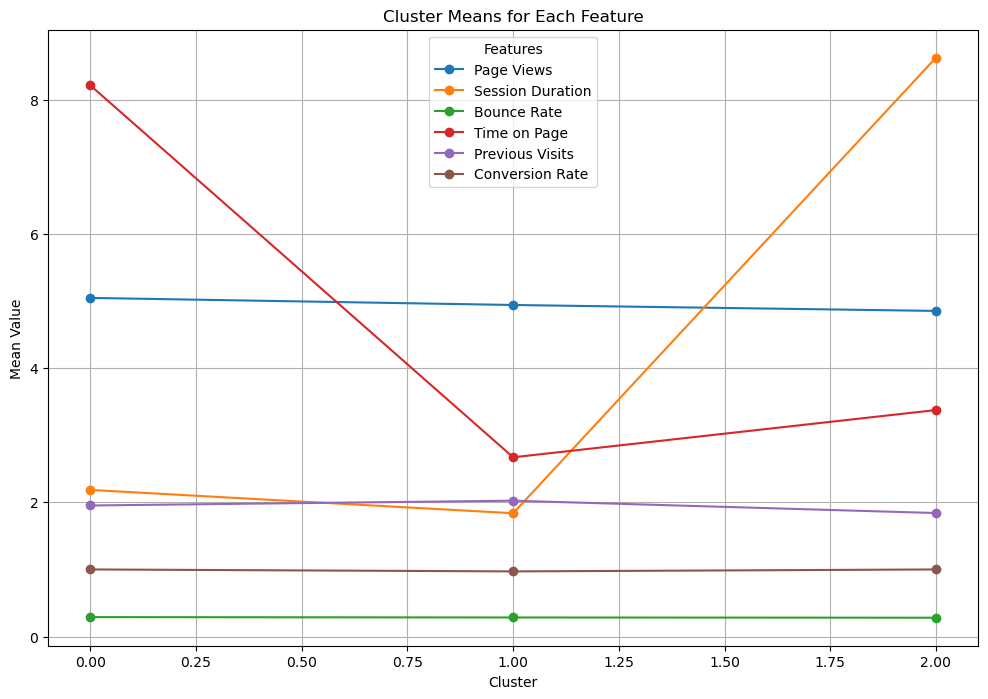

In [21]:
plt.figure(figsize=(12, 8))

for feature in cluster_means.columns:
    plt.plot(cluster_means.index, cluster_means[feature], marker='o', label=feature)

plt.title('Cluster Means for Each Feature')
plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.legend(title='Features')
plt.grid(True)
plt.show()